*Импортируем модули и настроим среду*

In [303]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Latex
from types import FunctionType
from functools import partial

plt.rcParams['figure.figsize'] = 8, 6
%config InlineBackend.figure_format = 'svg'

**Задание.** Реализовать в функциональной парадигме приближенное вычисление корней уравнения $f(x)$ с заданной (с клавиатуры при запуске) точностью $\epsilon$

In [304]:
eps = float(input())

display(Latex('$\epsilon$ равен $%s$' % eps))

<IPython.core.display.Latex object>

*__Этап 1 (Подготовительный).__ В силу ограничения заданием возможности использовать библиотеки, не включённые в список (напр., SymPy для символьных вычислений), реализуем функцию для приближенного вычисления значения производной. Для этого воспользуемся методом численного дифференцирования &ndash; <u>"Конечные Разности"</u>*

In [305]:
def dy(x, fn, n=1):
	h = 1e-5
	
	match n:
		case 1:
			return round((fn(x+h) - fn(x-h)) / (2*h), 5)
		case 2:
			return round((fn(x+h) - 2*fn(x) + fn(x-h)) / h**2, 5)
		case _:
			raise ValueError('No implementation for n is %s' % n)

*Реализуем функцию plot для визуализации графиков функций и их пересечений*

In [306]:
def plot(fn, xx, yy, root, title, show_axes=True):
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title(title)
  plt.plot(xx, yy, c='blue', label='$f(x)$')


  if type(fn) is FunctionType:
    plt.plot(xx, fn(xx), c='orange', label='$g(x)$')
    plt.plot(root, fn(root), 'ro')
  else:
    plt.axhline(fn, c='orange', label='$g(x)$')
    plt.plot(root, 0, 'ro')
    
  if show_axes:
    plt.axvline(x=0, c="gray", label="$x=0$", linewidth=0.5)
    plt.axhline(y=0, c="gray", label="$y=0$", linewidth=0.5)
	
  plt.legend()

*__Этап 2.__ Выполним приближённое вычисление корней уравнения $f(x)$ с заданной точностью $\epsilon$*

*__Теория:__ Численные методы решения уравнений сводятся к нахождению оптимального интервала изоляции, в котором функция будет сходиться к корню, и последовательным (итерационным) приближениям к нему*<br><br>
*<u>Примечание:</u> поиск оптимального интервала изоляции будем осуществлять методом машинной графики, т.е. поиском пересечений функции с осью абсцисс или другой равносильной функцией*

*a. $ln(x)+(x+1)^3=0$ методом касательных*

*Возьмём интервал $(0,1)$. Метод касательных сходится на малых интервалах, скорость сходимости варьируется от линейной до квадратичной*

<IPython.core.display.Latex object>

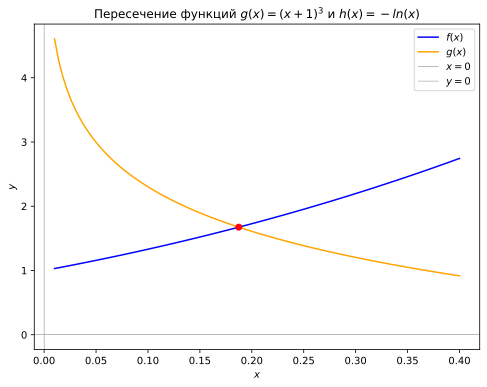

In [307]:
f = lambda x: np.log(x) + (x+1)**3
g = lambda x: (x+1)**3
h = lambda x: -np.log(x)


def find_root(x_prev):
  err = f(x_prev) / dy(x_prev, f)
  return find_root(x_prev - err) if abs(err) >= eps else x_prev - err


title = 'Пересечение функций $g(x)=(x+1)^3$ и $h(x)=-ln(x)$'
xx = np.linspace(0.01, 0.4, 100)
root = find_root(1)

display(Latex('Корень $f(x)$ на интервале $(0,1)$ равен $%s$' % root.round(3)))
plot(h, xx, g(xx), root, title)


*b. $(2-x)e^x=0$ методом половинного деления*

*Возьмём интервал $(2,3)$. Метод биссекции является априори сходимым с линейной скоростью сходимости*

<IPython.core.display.Latex object>

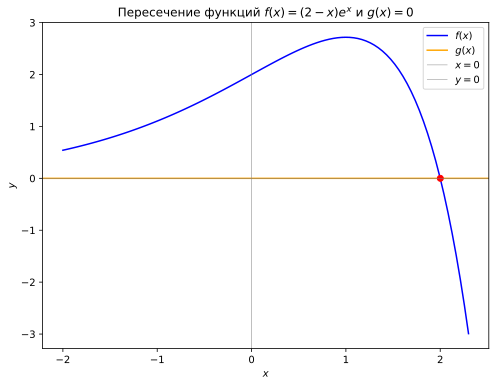

In [308]:
f = lambda x: (2-x)*np.e**x


def find_root(x1, x2):
  seg_len = x2 - x1
  seg_mean = x1 + seg_len / 2

  if (seg_len < eps*2):
    return seg_mean
    
  return find_root(x1, seg_mean) if np.sign(f(seg_mean)) != np.sign(f(x1)) else find_root(seg_mean, x2)


title = 'Пересечение функций $f(x)=(2-x)e^x$ и $g(x) = 0$'
xx = np.linspace(-2, 2.3, 100)
root = find_root(2, 3)

display(Latex('Корень $f(x)$ на интервале $(2,3)$ равен $%s$' % round(root, 3)))
plot(0, xx, f(xx), root, title)

*c. $x^2=ln(x+1)$ методом простых итераций*

*Путём эквивалентных преобразований приведём функцию $f(x)=0$ к виду $x=\phi(x)$, удобному для применения метода простой итерации. Итак, $\phi(x)=x-c(ln(x+1)-x^2)$*

*Оптимальное значение $c$ найдём по формуле $\frac{2}{(M+m)}$, где $M=max(f'(x))$, $m=min(f'(x))$. Такой подход обеспечивает сходимость как возрастающей, так и убывающей функции $f(x)$*

In [309]:
def find_c(x1, x2, f):
  extrema = dy(x1, f), dy(x2, f)
  return 2/(np.max(extrema) + np.min(extrema))

*Возьмём интервалы $(-0.5,0.5)$ для первого корня и $(0.5,1)$ для второго соответственно*

<IPython.core.display.Latex object>

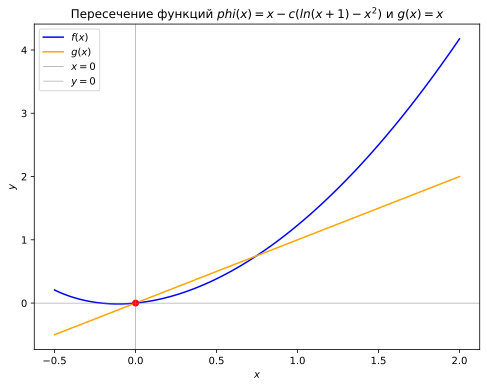

In [310]:
f = lambda x: np.log(x + 1) - x**2
phi = lambda x, c: x - c*(np.log(x + 1) - x**2)
g = lambda x: x

c = find_c(-0.5, 0.5, f)


def find_root(x, c):
  phi_ = partial(phi, c=c)
  return find_root(phi_(x), c) if np.abs(x - phi(x, c)) >= eps else x


title = 'Пересечение функций $phi(x)=x-c(ln(x + 1)-x^2)$ и $g(x)=x$'
xx = np.linspace(-0.5, 2, 100)
root = find_root(-0.5, c)

display(Latex(f'Корень $f(x)$ на интервале $(-0.5,0.5)$ равен ${root.round(3)}$'))
plot(g, xx, phi(xx, c), root, title)

<IPython.core.display.Latex object>

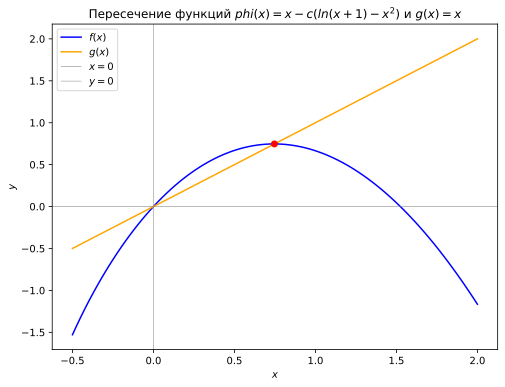

In [311]:
c = find_c(0.5, 1, f)
root = find_root(1, c)

display(Latex(f'Корень $f(x)$ на интервале $(0.5,1)$ равен ${root.round(3)}$'))
plot(g, xx, phi(xx, c), root, title)

*d. $lg(1+2x)=2-x$ методом хорд. Подобно методу кастельных, метод хорд сходится на малых интервалах, скорость сходимости линейная*

*Возьмём интервал $(1.2,1.6)$*

<IPython.core.display.Latex object>

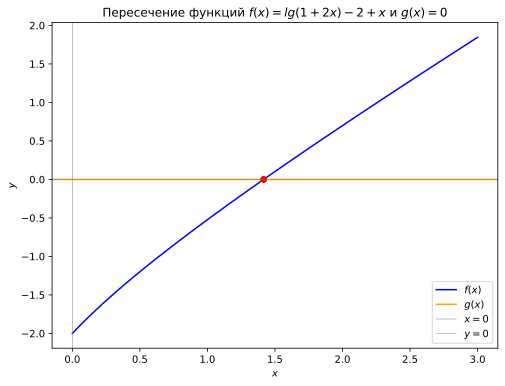

In [312]:
f = lambda x: np.log10(1+2*x) - 2+x


def find_root(x1, x2):
	xm = lambda x1, x2: (x1 * f(x2) - x2 * f(x1)) / (f(x2) - f(x1))
	
	xm1 = xm(x1, x2)
	xm2 = xm(x2, xm1)

	return xm1 if abs(xm2 - xm1) < eps else find_root(x2, xm1)


title = 'Пересечение функций $f(x)=lg(1+2x)-2+x$ и $g(x)=0$'
xx = np.linspace(0, 3, 100)
root = find_root(1.2, 1.6)

display(Latex('Корень $f(x)$ на интервале $(1.2,1.6)$ равен $%s$' % round(root, 3)))
plot(0, xx, f(xx), root, title)

*e. $2sin(x)-arctg(x)=0$ на промежутке $(2.5,2.6)$ методом простых итераций*

*Приведём функцию $f(x)=0$ к виду $x=\phi(x)$. На выходе получаем $\phi(x)=x-c(2sin(x)-arctg(x))$*

<IPython.core.display.Latex object>

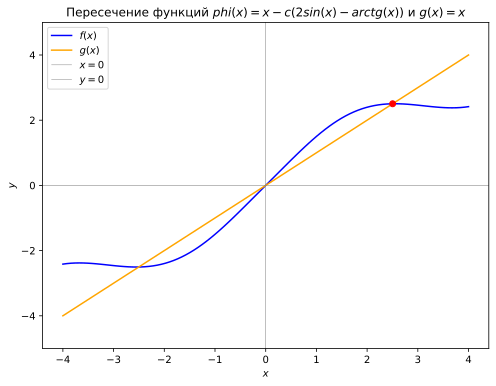

In [313]:
f = lambda x: 2*np.sin(x) - np.arctan(x)
phi = lambda x: x - c*(2*np.sin(x) - np.arctan(x))
g = lambda x: x

c = find_c(2.5, 2.6, f)


def find_root(x):
  return find_root(phi(x)) if np.abs(x - phi(x)) >= eps else x


title = 'Пересечение функций $phi(x)=x-c(2sin(x)-arctg(x))$ и $g(x)=x$'
xx = np.linspace(-4, 4, 100)
root = find_root(2.6)

display(Latex('Корень $f(x)$ на интервале $(2.5,2.6)$ равен $%s$' % round(root, 3)))
plt.ylim(-5, 5)
plot(g, xx, phi(xx), root, title)